In [1]:
import torch

In [2]:
print(torch.cuda.is_available())

False


In [3]:
print(torch.cuda.is_available()) # gpu가 있으면 True 없으면 False가 나온다.

False


In [4]:
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

/home/piai/anaconda3/envs/torch/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/piai/anaconda3/envs/torch/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [7]:
training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),
)

In [9]:
labels_map = {
    0 : "T-Shirt",
    1 : "Trouser",
    2 : "Pullover",
    3 : "Dress",
    4 : "Coat",
    5 : "Sandal",
    6 : "Shirt",
    7 : "Sneaker",
    8 : "Bag",
    9 : "Ankle Boot",
}

In [10]:
training_data[0][0].shape

torch.Size([1, 28, 28])

In [11]:
len(training_data)

60000

In [12]:
test_data[0][0].shape

torch.Size([1, 28, 28])

In [13]:
len(test_data)

10000

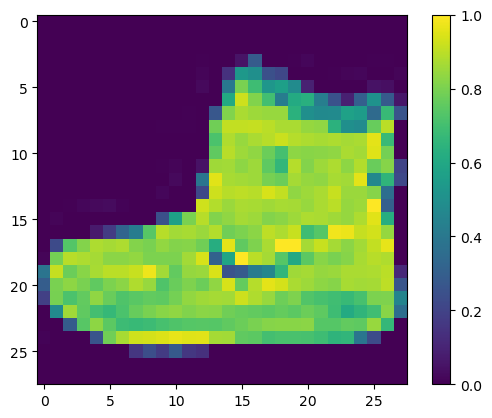

In [14]:
plt.figure()
plt.imshow(training_data[0][0].squeeze())
plt.colorbar()
plt.grid(False)
plt.show()

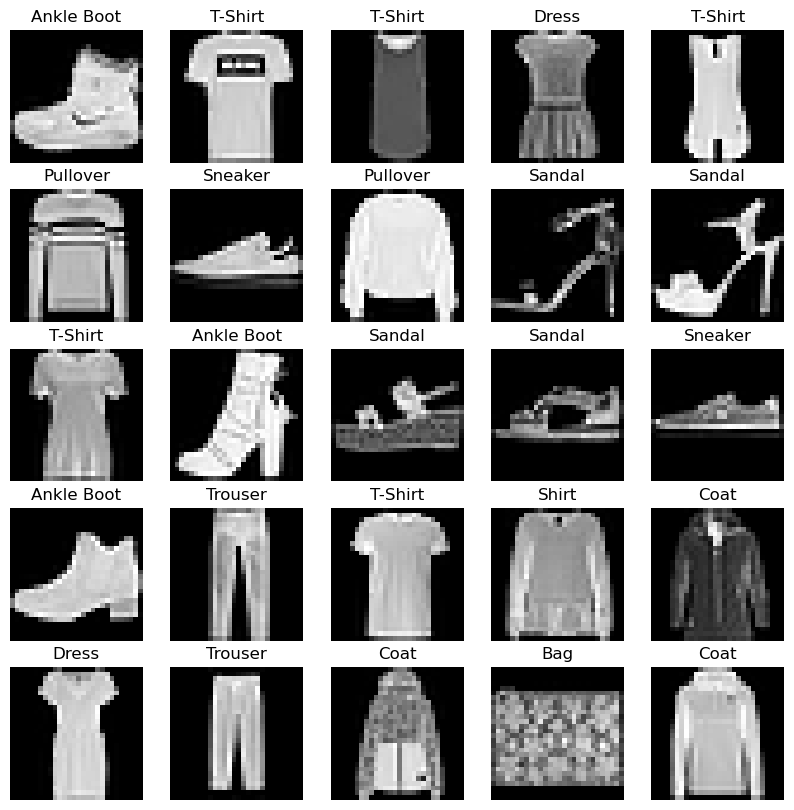

In [15]:
figure = plt.figure(figsize=(10,10))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = i -1
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [16]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [22]:
# 모델 구축
model = nn.Sequential(
    nn.Linear(32, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.Softmax()
)

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

Using cpu device


In [25]:
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [28]:
# 학습 설정
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [38]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [39]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [40]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
------------
loss: 0.306558 [    0/60000]
loss: 0.369525 [ 6400/60000]
loss: 0.291493 [12800/60000]
loss: 0.392761 [19200/60000]
loss: 0.446608 [25600/60000]
loss: 0.430757 [32000/60000]
loss: 0.374671 [38400/60000]
loss: 0.544950 [44800/60000]
loss: 0.458859 [51200/60000]
loss: 0.442410 [57600/60000]
Test Error: 
 Accuracy: 84.3%, Avg loss: 0.425099 

Epoch 2
------------
loss: 0.320202 [    0/60000]
loss: 0.310066 [ 6400/60000]
loss: 0.239361 [12800/60000]
loss: 0.373868 [19200/60000]
loss: 0.393864 [25600/60000]
loss: 0.343318 [32000/60000]
loss: 0.278866 [38400/60000]
loss: 0.412351 [44800/60000]
loss: 0.405248 [51200/60000]
loss: 0.399058 [57600/60000]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.395899 

Epoch 3
------------
loss: 0.281777 [    0/60000]
loss: 0.283570 [ 6400/60000]
loss: 0.215150 [12800/60000]
loss: 0.310464 [19200/60000]
loss: 0.353255 [25600/60000]
loss: 0.332004 [32000/60000]
loss: 0.245550 [38400/60000]
loss: 0.436382 [44800/60000]
loss: 0.339885 [51200

In [47]:
with torch.no_grad():
    predictions = [model(X.to(device))[0] for X,y in test_data]

In [48]:
predictions[0]

tensor([-12.7494, -11.1233, -17.7458, -13.3894, -15.4530,  -3.2324, -10.0055,
          0.2308,  -7.9345,   5.8285])

In [49]:
def plot_image(i, predictions_array, data):
    predictions_array, true_label, img = predictions_array[i].cpu().numpy(), data[i][1], data[i][0].squeeze()
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(labels_map[predicted_label],
                                        100*np.max(predictions_array),
                                        labels_map[true_label]),
              color=color)
    
def plot_value_array(i, predictions_array, data):
    predictions_array, true_label = predictions_array[i].cpu().numpy(), data[i][1]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0,1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

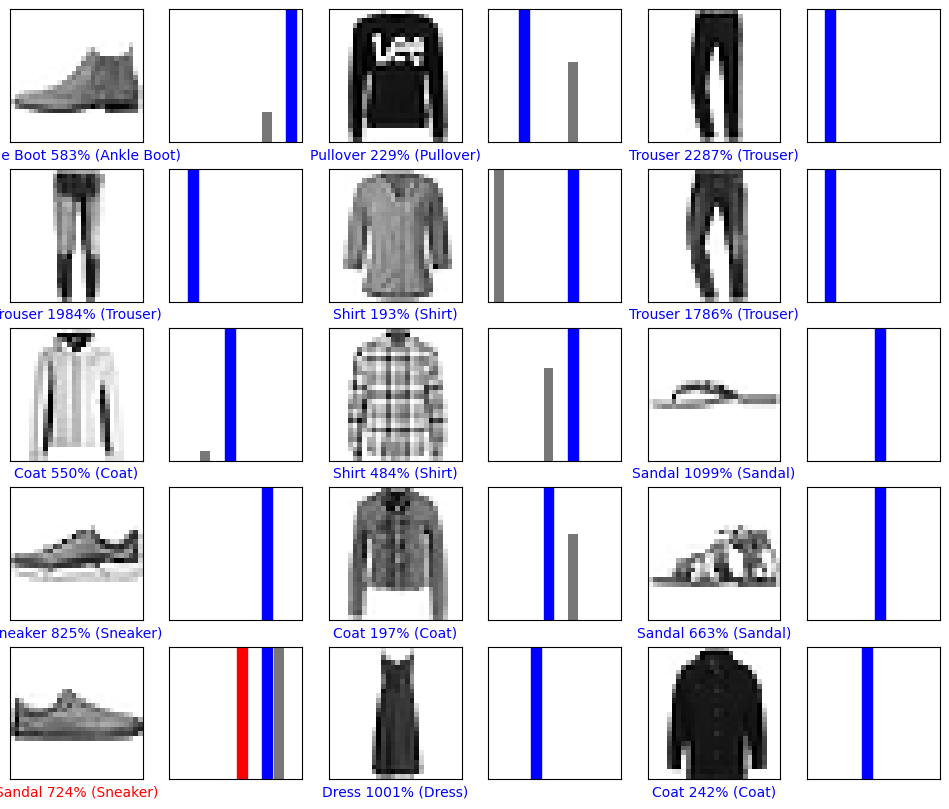

In [50]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_data)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_data)
plt.show()

In [52]:
torch.save(model.state_dict(), "./weights/my_model")

model = NeuralNetwork()
model.load_state_dict(torch.load("./weights/my_model"))

RuntimeError: Parent directory ./weights does not exist.